In [1]:
'''
https://github.com/Popgun-Labs/SincNetConv/blob/master/sincnetconv/sincnet_layers.py
test_model.hdf5 스펙
윈도윙 0.40
필터 파이 없음
'''
import os
import argparse
import keras
import pandas as pd

from keras.layers import Input
from keras.models import load_model
from data.batch import batch_inputs
from data import load_annotations
from utils import *
from new_sincnet import SincConv1D
from eval_sinc_model import resemul
keras.layers.TFRecordModel = TFRecordModel
from keras.models import Model
import numpy as np

import torch, math
import torch.nn.functional as F

MODEL_PATH = './0.9110.hdf5'
my_model = False

def extract_weights(model_or_path, data_dir, num_examples, num_audios_per_shard):
        os.environ['CUDA_VISIBLE_DEVICES']='1'
        test_path = '/home/jaehwlee/music-auto-tagging/sinc_resemul3/dataset/tfrecord/test-0042-of-0043.seq.tfrecord'

        segments, label = batch_inputs(
        file_pattern=make_path(data_dir, 'tfrecord', 'test-0042-of-0043.seq.tfrecord'),
        batch_size=1, is_training=False, is_sequence=True, examples_per_shard=num_audios_per_shard,
        num_read_threads=1, shard_queue_name='filename_queue', example_queue_name='input_queue')

        segments = Input(tensor=tf.squeeze(segments))
        label = Input(tensor=tf.squeeze(label))

        out = resemul(segments)
        model = TFRecordModel(inputs=segments, outputs=out)
        model.load_weights(model_or_path)
        # Create a model to extract excitations.

        sinc_input = model.layers[3].input
        excitations = model.layers[3].output
        f1, f2_1 = model.layers[3].get_weights()
        model_ex = TFRecordModel(inputs=model.inputs, outputs=excitations)
        model_input = TFRecordModel(inputs=model.inputs, outputs=sinc_input)
        # Extract excitations.
        outputs = model_ex.predict_tfrecord(segments)
        padding_input = model_input.predict_tfrecord(segments)
        return outputs, padding_input, f1, f2_1

def make_sinc_array(sinc_input):
    sinc_input = np.asarray(sinc_input)
    sinc_input = sinc_input[0].T
    sinc_input = sinc_input[0]
    return sinc_input


if my_model:
    sinc_output, sinc_input, my_low_hz, my_band_hz = extract_weights(MODEL_PATH, './dataset', 1, 1)
    my_sinc_input = make_sinc_array(sinc_input)
    my_sinc_output = make_sinc_array(sinc_output)
    print('=> Done.\n')

Using TensorFlow backend.
/home/jaehwlee/resemul/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import torch
import numpy as np
import math
def sinc(band, t_right):
    """
    :param band: (n_filt)
    :param t_right: K = filt_dim // 2 - 1
    :return: (n_filt, filt_dim)
    """
    n_filt = band.size(0)
    band = band[:, None]  # (n_filt, 1)
    t_right = t_right[None, :]  # (1, K)
    '''
    필터 부분
    이거는 if문 필요없는 부분인데;
    math.pi는 붙이던가 말던가
    '''
    if my_model:
        y_right = torch.sin(2  * band * t_right) / (2 * band * t_right)  # (n_filt, K)
    else:
        y_right = torch.sin(2  * math.pi* band * t_right) / (2  * math.pi * band * t_right)  # (n_filt, K)
    y_left = torch.flip(y_right, [1])
    y = torch.cat([y_left, torch.ones([n_filt, 1], device=band.device), y_right], dim=1)  # (n_filt, filt_dim)
    return y

In [3]:
def get_mel_points(fs, n_filt, fmin=80):
    """
    Return `n_filt` points linearly spaced in the mel-scale (in Hz)
    with an upper frequency of fs / 2
    :param fs: the sample rate in Hz
    :return: np.array (n_filt)
    """
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))
    mel_points = np.linspace(fmin, high_freq_mel, n_filt)  # equally spaced in mel scale
    f_cos = (700 * (10 ** (mel_points / 2595) - 1))
    return f_cos


In [4]:
def get_bands(f_cos, fs):
    """
    :param f_cos: vector of mel-scaled frequency (n_filt)
    :param fs: audio sample rate
    :return (b1, b1)
        b1: vector of lower cutoffs (n_filt)
        b2: vector of upper cutoffs
    """
    b1 = np.roll(f_cos, 1)
    b2 = np.roll(f_cos, -1)
    b1[0] = 30
    b2[-1] = (fs / 2) - 100
    return b1, b2

In [5]:
n_filt = 256
filt_dim = 2501
fs = 22050
min_freq = 50.0
min_band = 50.0

In [6]:
f_cos = get_mel_points(fs, n_filt)
b1, b2 = get_bands(f_cos, fs)

if my_model:
    filt_b1 = torch.from_numpy(my_low_hz).float()
    filt_band = torch.from_numpy(my_band_hz).float()
else:
    filt_b1 = torch.from_numpy(b1 / fs).float()
    filt_band = torch.from_numpy((b2 - b1) / fs).float()


In [7]:
hamming_window = torch.from_numpy(np.hamming(filt_dim)).float()
t_right = torch.linspace(1, (filt_dim - 1) / 2, steps=int((filt_dim - 1) / 2)) / fs

In [8]:
filt_beg_freq = torch.abs(filt_b1) + min_freq / fs
filt_end_freq = filt_beg_freq + (torch.abs(filt_band) + min_band / fs)

# construct the filter bank
low_pass1 = 2 * filt_beg_freq[:, None] * sinc(filt_beg_freq * fs, t_right)
low_pass2 = 2 * filt_end_freq[:, None] * sinc(filt_end_freq * fs, t_right)
band_pass = (low_pass2 - low_pass1)
max_band, _ = torch.max(band_pass, dim=1, keepdim=True)
band_pass = band_pass / max_band  # (n_filt, filt_dim)
filters = band_pass * hamming_window[None, ]  # (n_filt, filt_dim)

In [10]:
# sum = 0
# my_filter = filters.tolist()
# for i, j in zip(my_sinc_input[:2501],my_filter[0]):
#     sum += i*j
# print(sum)
# print(my_sinc_output[0])

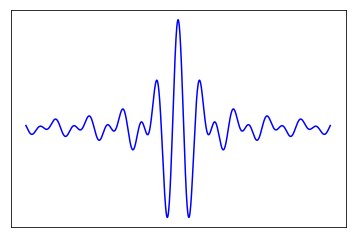

In [45]:
'''
time domain
'''
import matplotlib.pyplot as plt
y255 = band_pass[0].tolist()
x = list(range(0,2501))

plt.xticks([])
plt.yticks([])
plt.plot(x,y255, 'b')

([], <a list of 0 Text yticklabel objects>)

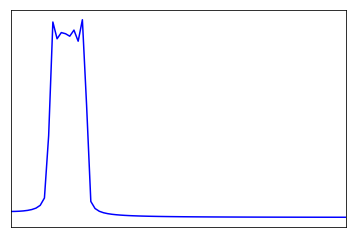

In [47]:
Fs = 22050
n=len(y255)        # Length of signal
NFFT=n      # ?? NFFT=2^nextpow2(length(y))  ??
k=np.arange(NFFT)
f0=k*Fs/NFFT    # double sides frequency range
f0=f0[range(math.trunc(NFFT/2))]        # single sied frequency range

Y=np.fft.fft(y255)/NFFT        # fft computing and normaliation
Y=Y[range(math.trunc(NFFT/2))]          # single sied frequency range
amplitude_Hz = 2*abs(Y)
phase_ang = np.angle(Y)*180/np.pi
plt.xlim( 0,700)
#fig = plt.figure(figsize=(20, 3))
plt.plot(f0,amplitude_Hz,'b')   #  2* ???
    
plt.xticks([])
plt.yticks([])
#plt.plot(x,y255)

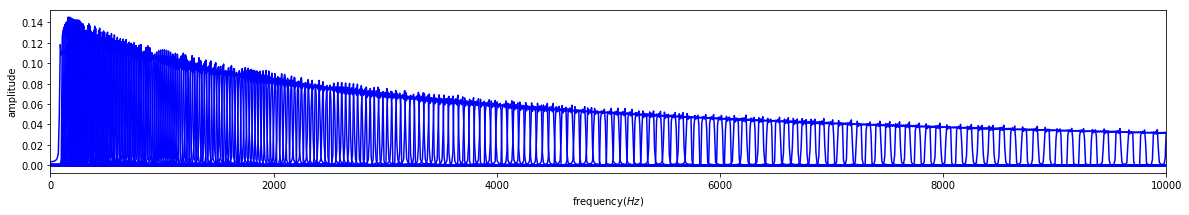

In [13]:
'''
frequency domain
'''
def preprocess_band_pass(i):
    return band_pass[i].tolist()

def draw(i):
    a = preprocess_band_pass(i)
    my_n=len(a)        # Length of signal
    NFFT=my_n      # ?? NFFT=2^nextpow2(length(y))  ??
    k=np.arange(NFFT)
    f0=k*fs/NFFT    # double sides frequency range
    f0=f0[range(math.trunc(NFFT/2))]        # single sied frequency range
    Y=np.fft.fft(a)/NFFT        # fft computing and normaliation
    Y=Y[range(math.trunc(NFFT/2))]          # single sied frequency range
    amplitude_Hz = 2*abs(Y)
    #fig = plt.figure(figsize=(20, 3))
    plt.plot(f0,amplitude_Hz,'b')   #  2* ???
    plt.xlim( 0,10000)
    plt.xlabel('frequency($Hz$)')
    plt.ylabel('amplitude')
    plt.grid()
plt.figure(figsize=(20,3))

for i in range(0, 256,1):
    draw(i)


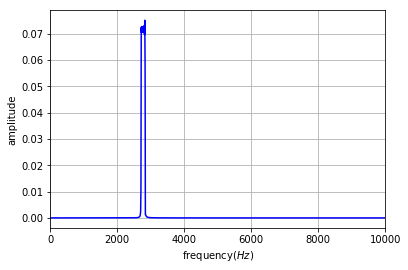

In [17]:
draw(140)